### Automatic Port Operations with Image Recognition using a Convolutional Neural Network and Transfer learning model with MobileNet ###

In [190]:
# lets define some constants
boats_dir = '/kaggle/input/boats-zip-file/TRAIN_BOATS'

height = 255
width = 255
batch_size = 32
total_train_images = 1162
total_test_images = 300

print('Done')

Done


In [191]:
import pathlib
data_dir = pathlib.Path(boats_dir)
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

1162


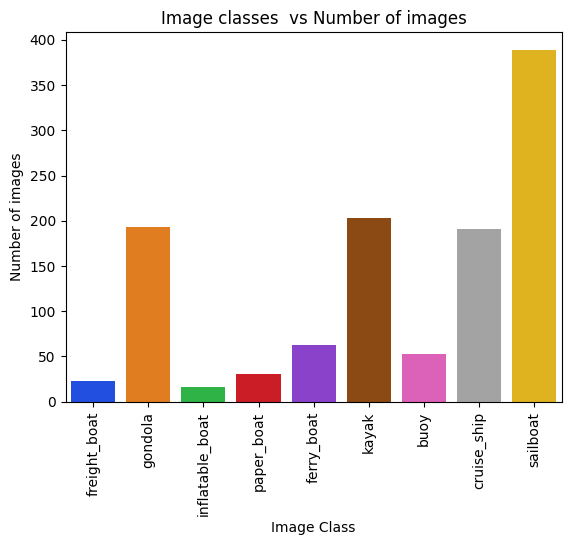

freight_boat  gondola  inflatable_boat  paper_boat  ferry_boat  kayak  \
0            23      193               16          31          63    203   

   buoy  cruise_ship  sailboat  
0    53          191       389

In [192]:
import os
import seaborn as sns
import pandas as pd

def get_subdirectories(directory):
    with os.scandir(directory) as entries:
        return [entry.name for entry in entries if entry.is_dir()]
sub_dirs = get_subdirectories(data_dir)
images = {}

for d in sub_dirs:

    images[d] = [len(os.listdir(boats_dir+'/'+d))]

df = pd.DataFrame(images)
sns.barplot(data = df ,palette= sns.color_palette("bright"))
plt.xlabel('Image Class')
plt.ylabel('Number of images')
plt.title(f'Image classes  vs Number of images' )
plt.xticks(rotation = 90)
plt.show()
df

There is a predominence of the sailboat class in the training data. Images classes gondola, kayak and cruise ships are also non-trivial. We can therefor expect mistclassification of the other image classes as thse main majority classes

In [193]:
# using the latest tf.data for efficient input pipelines. 
# The td.data.Dataset provides APIS to efficiently cache image data in the memory and prefetch images while a step is executing.
# I wil be using this feature for faster training
# https://www.tensorflow.org/guide/data

import tensorflow as tf
def get_ds(data_dir,validation_split=0.2,subset='training',seed = 43,image_size=(255,255),batch_size=32):
    train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=validation_split,
    subset=subset,
    seed=seed,
    image_size=image_size,
    batch_size=batch_size)
    train_ds.class_names
    return train_ds

train_ds = get_ds(data_dir,image_size=(height,width),batch_size=batch_size)

Found 1162 files belonging to 9 classes.
Using 930 files for training.


In [194]:
val_ds = get_ds(data_dir,validation_split=0.2,subset='validation',seed = 43,image_size=(height,width),batch_size=batch_size)

Found 1162 files belonging to 9 classes.
Using 232 files for validation.


In [195]:
class_names = train_ds.class_names
print(class_names)

['buoy', 'cruise_ship', 'ferry_boat', 'freight_boat', 'gondola', 'inflatable_boat', 'kayak', 'paper_boat', 'sailboat']


Some sample images from the training split is displayed below

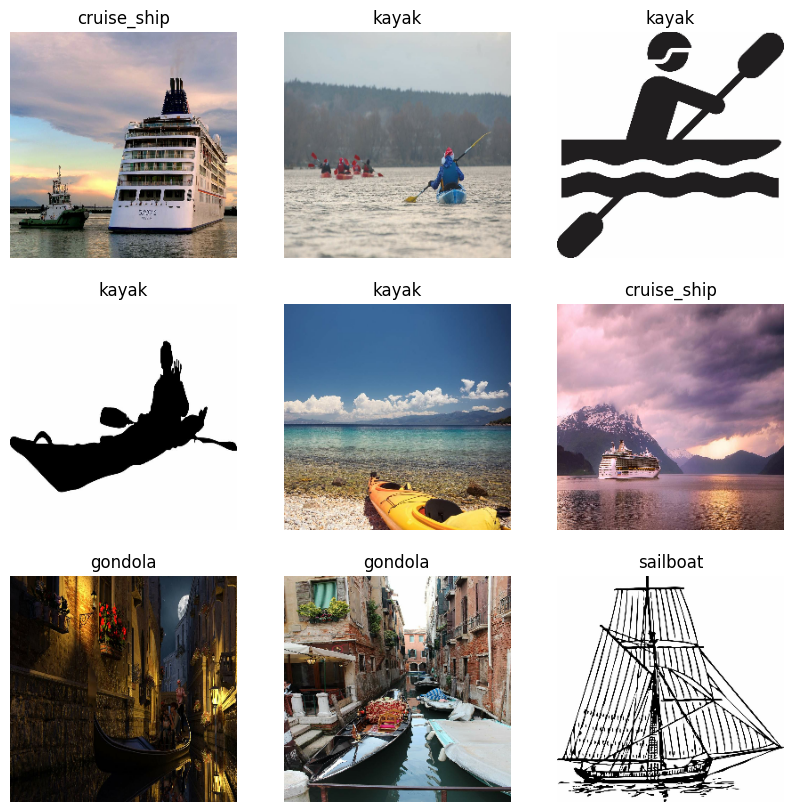

In [196]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))

for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

https://www.tensorflow.org/guide/data_performance

Using cache, prfetch and AUTOTUNE for efficient handling of input data

In [197]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [198]:
# import library
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow import keras
import warnings
warnings.filterwarnings('ignore')

model = Sequential([
  ##--- starting data augmenttaion
  layers.RandomFlip("horizontal",input_shape=(height,width,3)),
  layers.RandomRotation(0.1),
  layers.RandomZoom(0.1),
  #layers.RandomShear(x_factor=0.1, y_factor=0.1),
  ##---- Data Augmentation ends
  layers.Rescaling(1./255, input_shape=(height, width, 3)), #Scale the pixels
  layers.Conv2D(32, (3,3), padding='same', activation='relu'), # convolutiion with 16 fillters with a 3x3 kernal matrix
  layers.MaxPooling2D(), # Use max pooling

  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),


  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),


  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.GlobalMaxPooling2D(),
  layers.Dropout(0.2),  # one global dropout

  layers.Flatten(), # flatten the input for feeding to ANN
  layers.Dense(128, activation='relu'), # ANN hidde layer with 128 neurons
  layers.Dense(len(class_names)) # ANN output layer

])
# comple the model
model.compile(optimizer='adam',
              # Recomended for sparse matrix data ( which images are)
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              #This does not work 
              # metrics=[keras.metrics.Accuracy(),keras.metrics.Precision(),keras.metrics.Recall()]
              metrics=['accuracy']
             )
model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ random_flip_8 (RandomFlip)           │ (None, 255, 255, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation_8 (RandomRotation)   │ (None, 255, 255, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_zoom_8 (RandomZoom)           │ (None, 255, 255, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_2 (Rescaling)              │ (None, 255, 255, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 255, 255, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 127, 127, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 63, 63, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 31, 31, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 31, 31, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling2d_2               │ (None, 128)                 │               0 │
│ (GlobalMaxPooling2D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 120,169 (469.41 KB)

 Trainable params: 120,169 (469.41 KB)

 Non-trainable params: 0 (0.00 B)

I have extended the ModelCheckpoint class so that I can extract the epoch number at which the training ended. ModelCheckpoint does not save this parameteer as pasrt of its init(it stores save_freq = epoch , which is a string). I have overrided the on_epoch_end method to extract the last epoh at which training stopped which can then be used seamlessly in plotting accuracy and loss graphs

In [199]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Extending the ModelCheckPoint class
class MyCheckpoint(ModelCheckpoint):

    def __init__(self,
                 filepath,
                 monitor="val_loss",
                 verbose=0,
                 save_best_only=False,
                 save_weights_only=False,
                 mode="auto",
                 save_freq="epoch",
                 initial_value_threshold=None,
                 ):
        super().__init__(filepath,
                         monitor,
                         verbose,
                         save_best_only,
                         save_weights_only,
                         mode,
                         save_freq,
                         initial_value_threshold)

        self.last_epoch_number = 0
    # This function is called at the end of each epoch. I am overriding this method
    def on_epoch_end(self,epoch,logs=None):
        super().on_epoch_end(epoch,logs)
        self.last_epoch_number =  epoch+1
        print(f'epoch {self.last_epoch_number} completed')


In [200]:
from tensorflow.keras.callbacks import EarlyStopping


early_stop=EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=10,min_delta=0.01)
checkpoint=MyCheckpoint('best_model.keras',monitor='val_loss',mode='min',verbose=1,save_best_only=True)

epochs=100
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  batch_size = batch_size,
  # not specified. But i thought this was a good idea
  callbacks = [early_stop,checkpoint]
)

Epoch 1/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.2280 - loss: 1.9908
Epoch 1: val_loss improved from inf to 1.85290, saving model to best_model.keras
epoch 1 completed
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 84ms/step - accuracy: 0.2293 - loss: 1.9880 - val_accuracy: 0.3017 - val_loss: 1.8529
Epoch 2/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.3402 - loss: 1.8079
Epoch 2: val_loss improved from 1.85290 to 1.81073, saving model to best_model.keras
epoch 2 completed
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.3403 - loss: 1.8085 - val_accuracy: 0.3017 - val_loss: 1.8107
Epoch 3/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.3605 - loss: 1.7728
Epoch 3: val_loss improved from 1.81073 to 1.79777, saving model to best_model.keras
epoch 3 completed
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.3600 - loss: 1.7739 - val_accuracy: 0.3017 - val_loss: 1.7978
Epoch 4/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.3331 - loss: 1.7971
Epo

In [201]:
# print training accuracy
def print_scores(model,val_ds,train_ds):
  score_test = model.evaluate(val_ds, verbose=0)
  print('Test loss:%.4f' % score_test[0])
  print('Test accuracy:%.4f'% score_test[1])
  score_train= model.evaluate(train_ds, verbose=0)
  print('Train loss:%.4f'% score_train[0])
  print('train accuracy:%.4f'% score_train[1])
print_scores(model,val_ds,train_ds)

Test loss:1.2545
Test accuracy:0.6552
Train loss:0.6063
train accuracy:0.7989


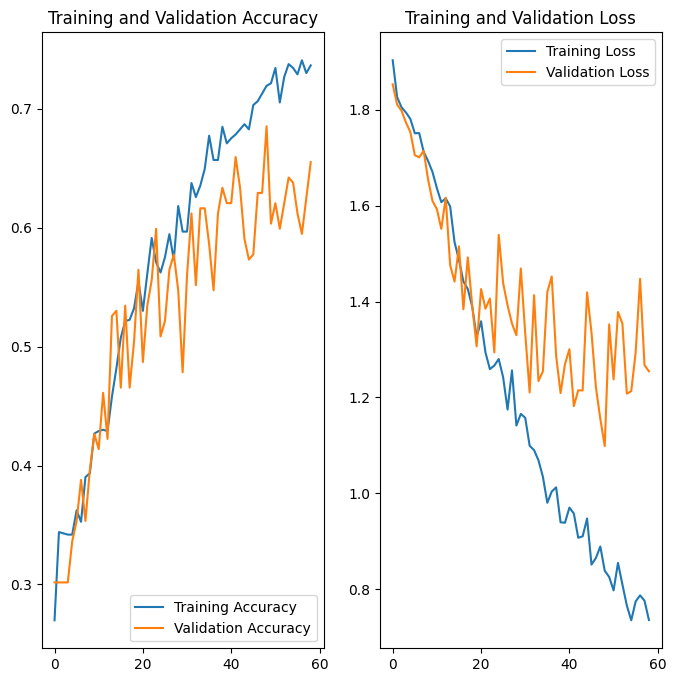

In [202]:
import matplotlib.pyplot as plt
def plot_accuracy_loss_graphs(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs_range = range(checkpoint.last_epoch_number)

  plt.figure(figsize=(8, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()
plot_accuracy_loss_graphs(history)

Model performance evaluation

In [203]:
import numpy as np
import os

# Collect images in differnet lists based on the confidence score.We will create 10 bins

test_dir = '/kaggle/input/boats-zip-file/TEST_BOATS/all'

def get_predicted_labels(model):
    '''
    param : a Sequential model
    returns : a dictionary of image_paths and predicted labels
    
    '''
    images = os.listdir(test_dir)
    image_label_map = {}

    for i, image in enumerate(images):
        path = test_dir+'/'+image
        img = tf.keras.utils.load_img(path, target_size=(height, width))
        img_array = tf.keras.utils.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0) # Create a batch
        predictions = model.predict(img_array,verbose=False)
        score = tf.nn.softmax(predictions[0])
        max_score = np.max(score)
        image_label_map[path] = class_names[np.argmax(score)]
        

    return image_label_map

Get the Images based on confidence

In [204]:
# get the images based on confidence
image_map = get_predicted_labels(model)
print('size of image map = ',len(image_map))


size of image map =  300


**Visualize the predictions**

Predictions for CNN Model



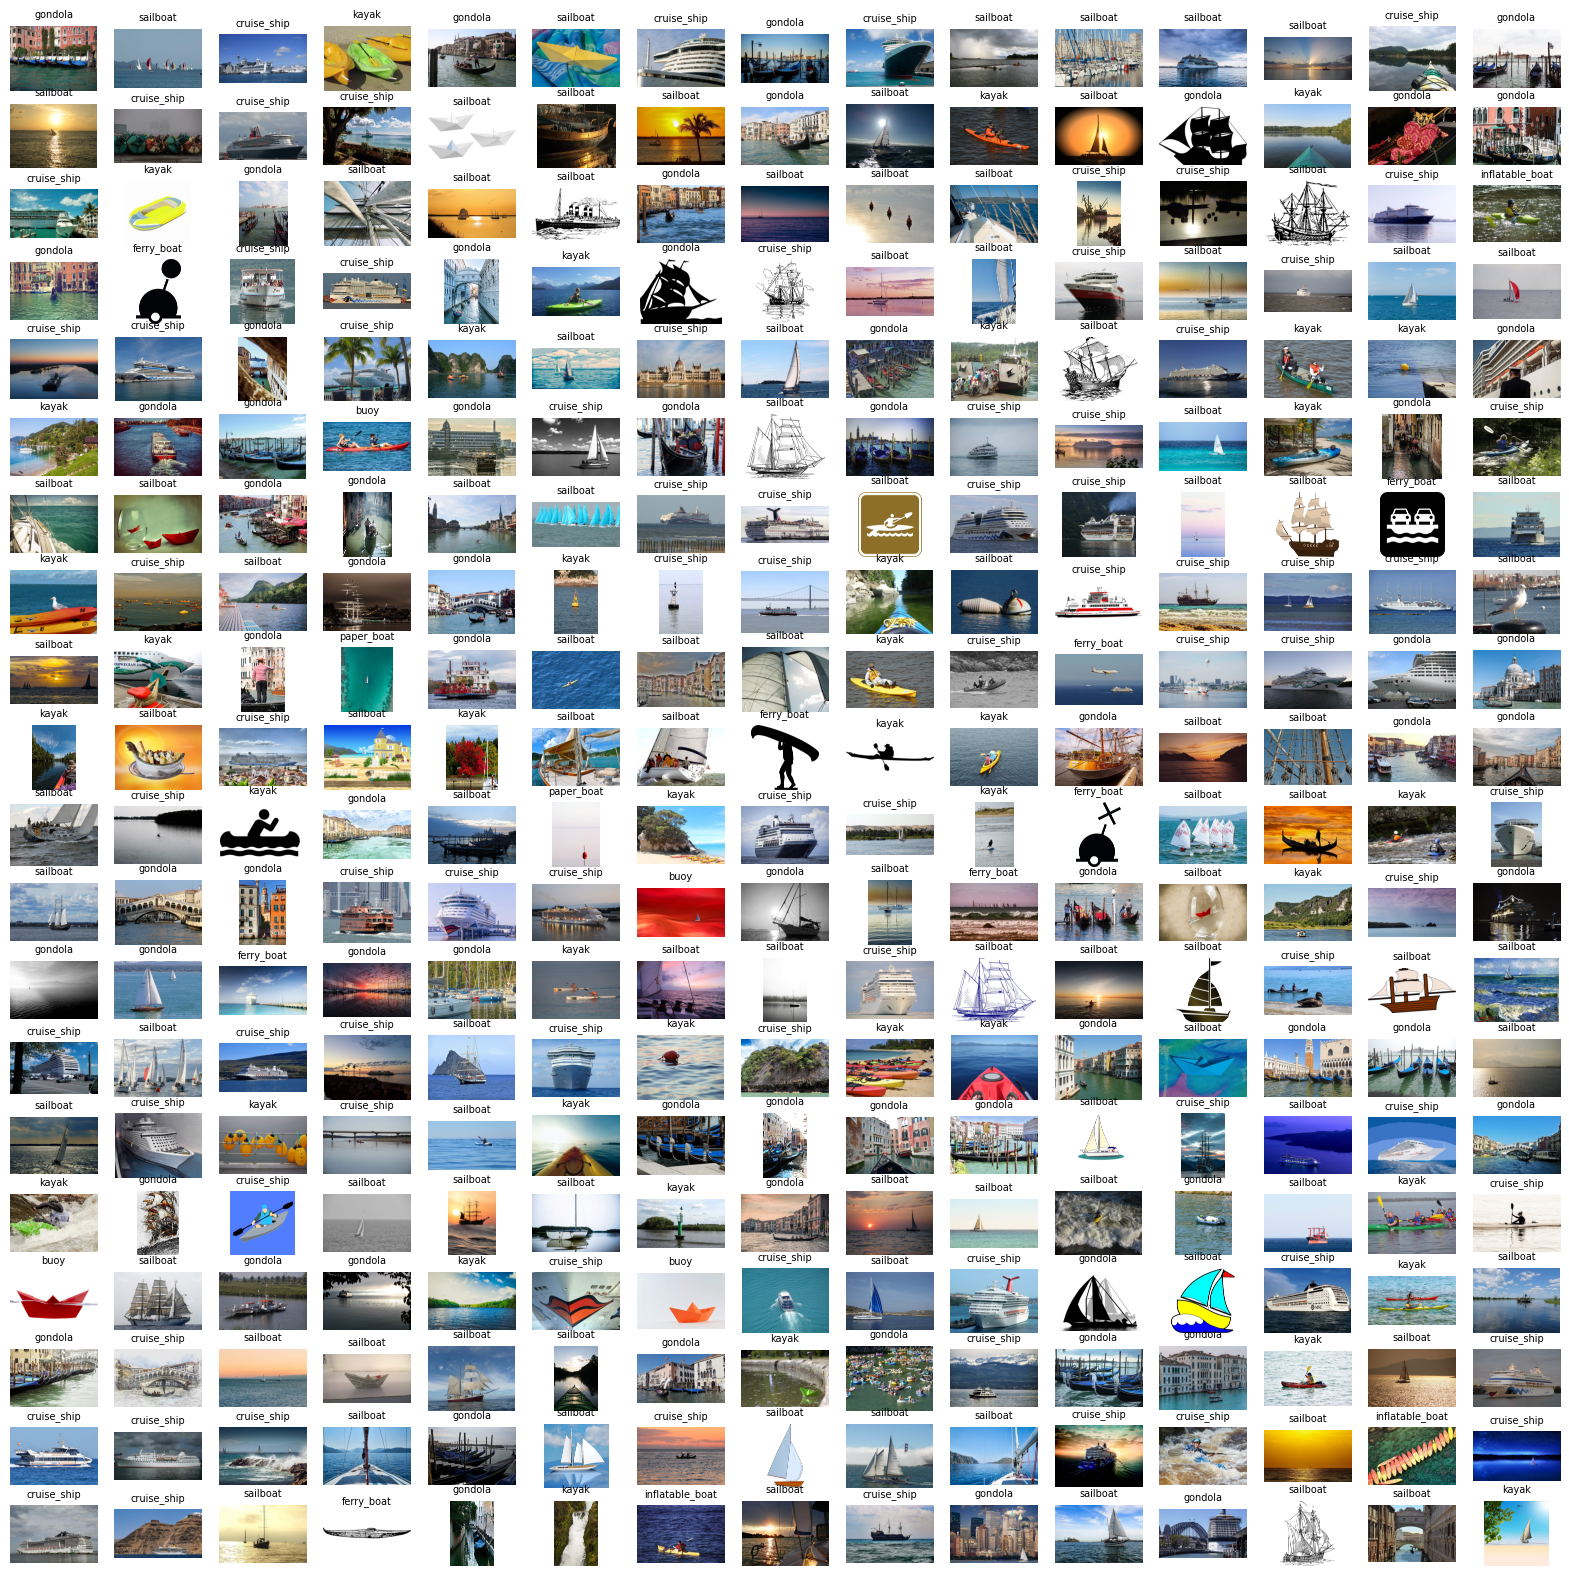

In [205]:
import matplotlib.image as mpimg

def display_test_images(image_map,model_name):
    print(f'Predictions for {model_name}\n')
    plt.figure(figsize=(20,20))
    for  i, image_path in enumerate(image_map.keys()):
        plt.subplot(20,15,i+1)
        img = mpimg.imread(image_path)
        plt.imshow(img)
        plt.axis('off') 
        plt.title(image_map.get(image_path),fontsize=7, fontweight=20)
    plt.show()
display_test_images(image_map,'CNN Model')

**Metrics calculation. For doing this, we need true and predicted labels for the validation dataset**

In [206]:
def count_elements(dataset):
    return sum(1 for _ in dataset)

In [207]:
from sklearn.metrics import confusion_matrix
def get_metrics(model,validation_ds,val_split = 0.2):
    num_images = int(total_train_images * val_split)
    num_batches = int(num_images/32)
    residuals = int(num_images % 32)
    print(num_images,num_batches,residuals)
    true_labels = []
    predicted_labels = []
    for images, labels in test_ds.take(num_batches): 
      true_labels.extend(labels)
      for i in range(batch_size): # prediction for each image in the batch
          img_array = tf.keras.utils.img_to_array(images[i])
          img_array = tf.expand_dims(img_array, 0) # Create a batch
          predictions= model.predict(img_array,verbose=False)
          score = tf.nn.softmax(predictions[0])
          predicted_labels.append(np.argmax(score))
    # True and predicted labels should match
    print(len(true_labels),len(predicted_labels))
    return true_labels, predicted_labels
true_labels, predicted_labels = get_metrics(model,val_ds)

232 7 8
224 224


**Confusion Matrix**

Confusion Matrix
[[ 4  0  0  0  0  0  2  0  4]
 [ 0 36  0  0  2  0  0  0  4]
 [ 0  2  4  0  0  0  1  0  6]
 [ 0  1  0  1  1  0  0  0  4]
 [ 0  1  0  1 31  0  0  0  2]
 [ 0  0  0  0  1  0  2  0  0]
 [ 0  4  1  0  2  1 26  0  4]
 [ 1  0  0  0  0  0  1  5  0]
 [ 0  1  1  1  5  0  2  0 59]]

Confusion Matrix Displayed



<Figure size 1000x1000 with 0 Axes>

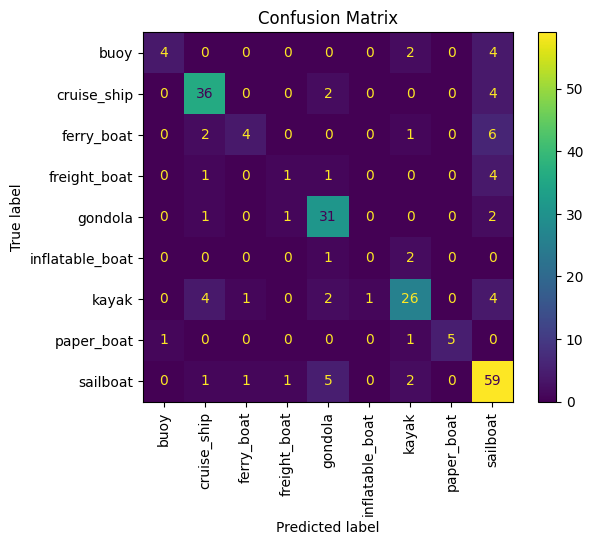

In [208]:
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(true_labels,predicted_labels)
print('Confusion Matrix')
print(cm)
print()

print('Confusion Matrix Displayed\n')
plt.figure(figsize = (10,10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_names)
disp.plot()
plt.title('Confusion Matrix')
plt.xticks(rotation=90)
plt.show()

As expected Sailboat,Kayak,Gondola and Cruise ship has high true positive values because of large number of images in the training data. Most mis-classifications are seen in the other image classes

**Classification Report**

In [209]:
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings('ignore')

cl_report = classification_report(true_labels,predicted_labels)
print(cl_report)

              precision    recall  f1-score   support

           0       0.80      0.40      0.53        10
           1       0.80      0.86      0.83        42
           2       0.67      0.31      0.42        13
           3       0.33      0.14      0.20         7
           4       0.74      0.89      0.81        35
           5       0.00      0.00      0.00         3
           6       0.76      0.68      0.72        38
           7       1.00      0.71      0.83         7
           8       0.71      0.86      0.78        69

    accuracy                           0.74       224
   macro avg       0.65      0.54      0.57       224
weighted avg       0.73      0.74      0.72       224



## Transfer Learning with MobileNet application ##

In [210]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
print('imported')

imported


In [211]:
mob_model = tf.keras.applications.MobileNet(
    input_shape=(height,width,3),
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
    name='MobileNet',
)

**Build an FCN**

In [212]:
train_ds = get_ds(data_dir,validation_split=0.3,subset='training',seed = 1,image_size=(height,width),batch_size=batch_size)

Found 1162 files belonging to 9 classes.
Using 814 files for training.


In [213]:
val_ds = get_ds(data_dir,validation_split=0.3,subset='validation',seed = 1,image_size=(height,width),batch_size=batch_size)

Found 1162 files belonging to 9 classes.
Using 348 files for validation.


In [214]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [229]:

mob_model.trainable=False
model_t=Sequential()
model_t.add(mob_model)

model_t.add(layers.RandomFlip("horizontal",input_shape=(height,width,3)))
model_t.add(layers.RandomRotation(0.1))
model_t.add(layers.RandomZoom(0.1))
# model_t.add(layers.RandomShear(x_factor=0.1, y_factor=0.1))

model_t.add(layers.GlobalAveragePooling2D())

## Dropout at 0.5 produces much lesse overfitting. 
## Any lesser value increases training accuracy substantially, but testing acuracy doesnt improve
## Using Dropout as 0.1 as specified in the problem statement gives a training accuracy of 1, but a tetsing accuracy of 65%
## and results in worse classification

model_t.add(layers.Dropout(0.5)) # 


model_t.add(layers.Dense(256, activation='relu'))
model_t.add(layers.BatchNormalization())
model_t.add(layers.Dropout(0.5))

model_t.add(layers.Dense(128, activation='relu'))
model_t.add(layers.BatchNormalization())
model_t.add(layers.Dropout(0.5))

model_t.add(layers.Dense(len(class_names),activation='softmax'))
model_t.summary()


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ MobileNet (Functional)               │ (None, 8, 8, 1024)          │       3,228,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_flip_11 (RandomFlip)          │ (None, 8, 8, 1024)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation_11 (RandomRotation)  │ (None, 8, 8, 1024)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_zoom_11 (RandomZoom)          │ (None, 8, 8, 1024)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_8           │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_27 (Dropout)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 256)                 │         262,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_28 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_29 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_32 (Dense)                     │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,526,857 (13.45 MB)

 Trainable params: 297,225 (1.13 MB)

 Non-trainable params: 3,229,632 (12.32 MB)

In [225]:
### Two problems i faced here.
# 1. categorical_crossentropy doesnt work. Documenation says that categorical_crossentropy should be used for one-hot encoded features.
#     Otherwise sparse_categorical_crossentropy should be used
# 2. The problem statement asks to compile using accuracy, precision and recall for metrics
#    However this does not work:
#    metrics=['accuracy','precision','recall']
#    Infact, no other value other than accuracy works for metrics

model_t.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [226]:

early_stop=EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=10,min_delta=0.01)
checkpoint=MyCheckpoint('best_model.keras',monitor='val_loss',mode='min',verbose=1,save_best_only=True)

epochs=100
history_t = model_t.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  batch_size = batch_size,
  # not specified. But i thought this was a good idea
  callbacks = [early_stop,checkpoint]
)

Epoch 1/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.1109 - loss: 3.4202
Epoch 1: val_loss improved from inf to 1.94873, saving model to best_model.keras
epoch 1 completed
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 114ms/step - accuracy: 0.1114 - loss: 3.4138 - val_accuracy: 0.3563 - val_loss: 1.9487
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.2143 - loss: 2.7583
Epoch 2: val_loss improved from 1.94873 to 1.71431, saving model to best_model.keras
epoch 2 completed
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - accuracy: 0.2142 - loss: 2.7576 - val_accuracy: 0.4339 - val_loss: 1.7143
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.3370 - loss: 2.2124
Epoch 3: val_loss improved from 1.71431 to 1.64117, saving model to best_model.keras
epoch 3 completed
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - accuracy: 0.3369 - loss: 2.2136 - val_accuracy: 0.4741 - val_loss: 1.6412
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.3890 - loss: 2.1200
Ep

Test loss:1.0324
Test accuracy:0.6580
Train loss:0.5687
train accuracy:0.8170


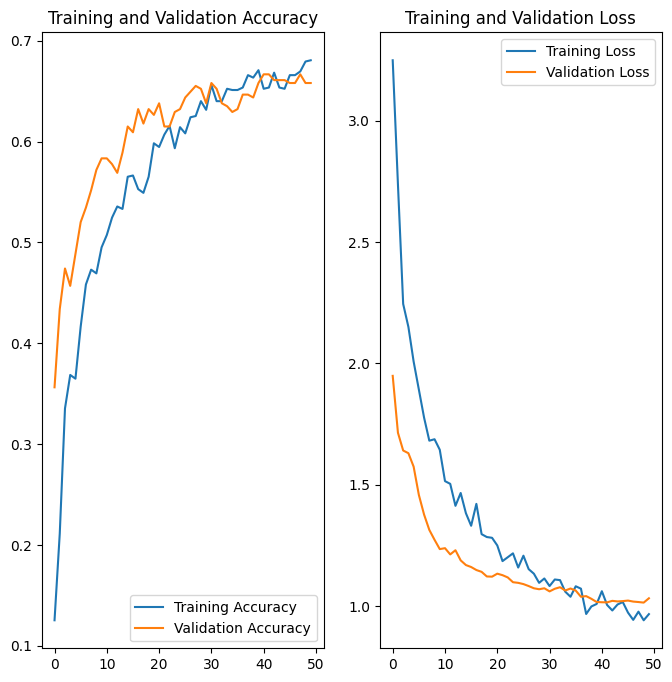

In [227]:
print_scores(model_t,val_ds,train_ds)
plot_accuracy_loss_graphs(history_t)

In [228]:
image_map = get_predicted_labels(model_t)
print('size of image map = ',len(image_map))


size of image map =  300


Predictions for Transfer Learning model using MobileNet



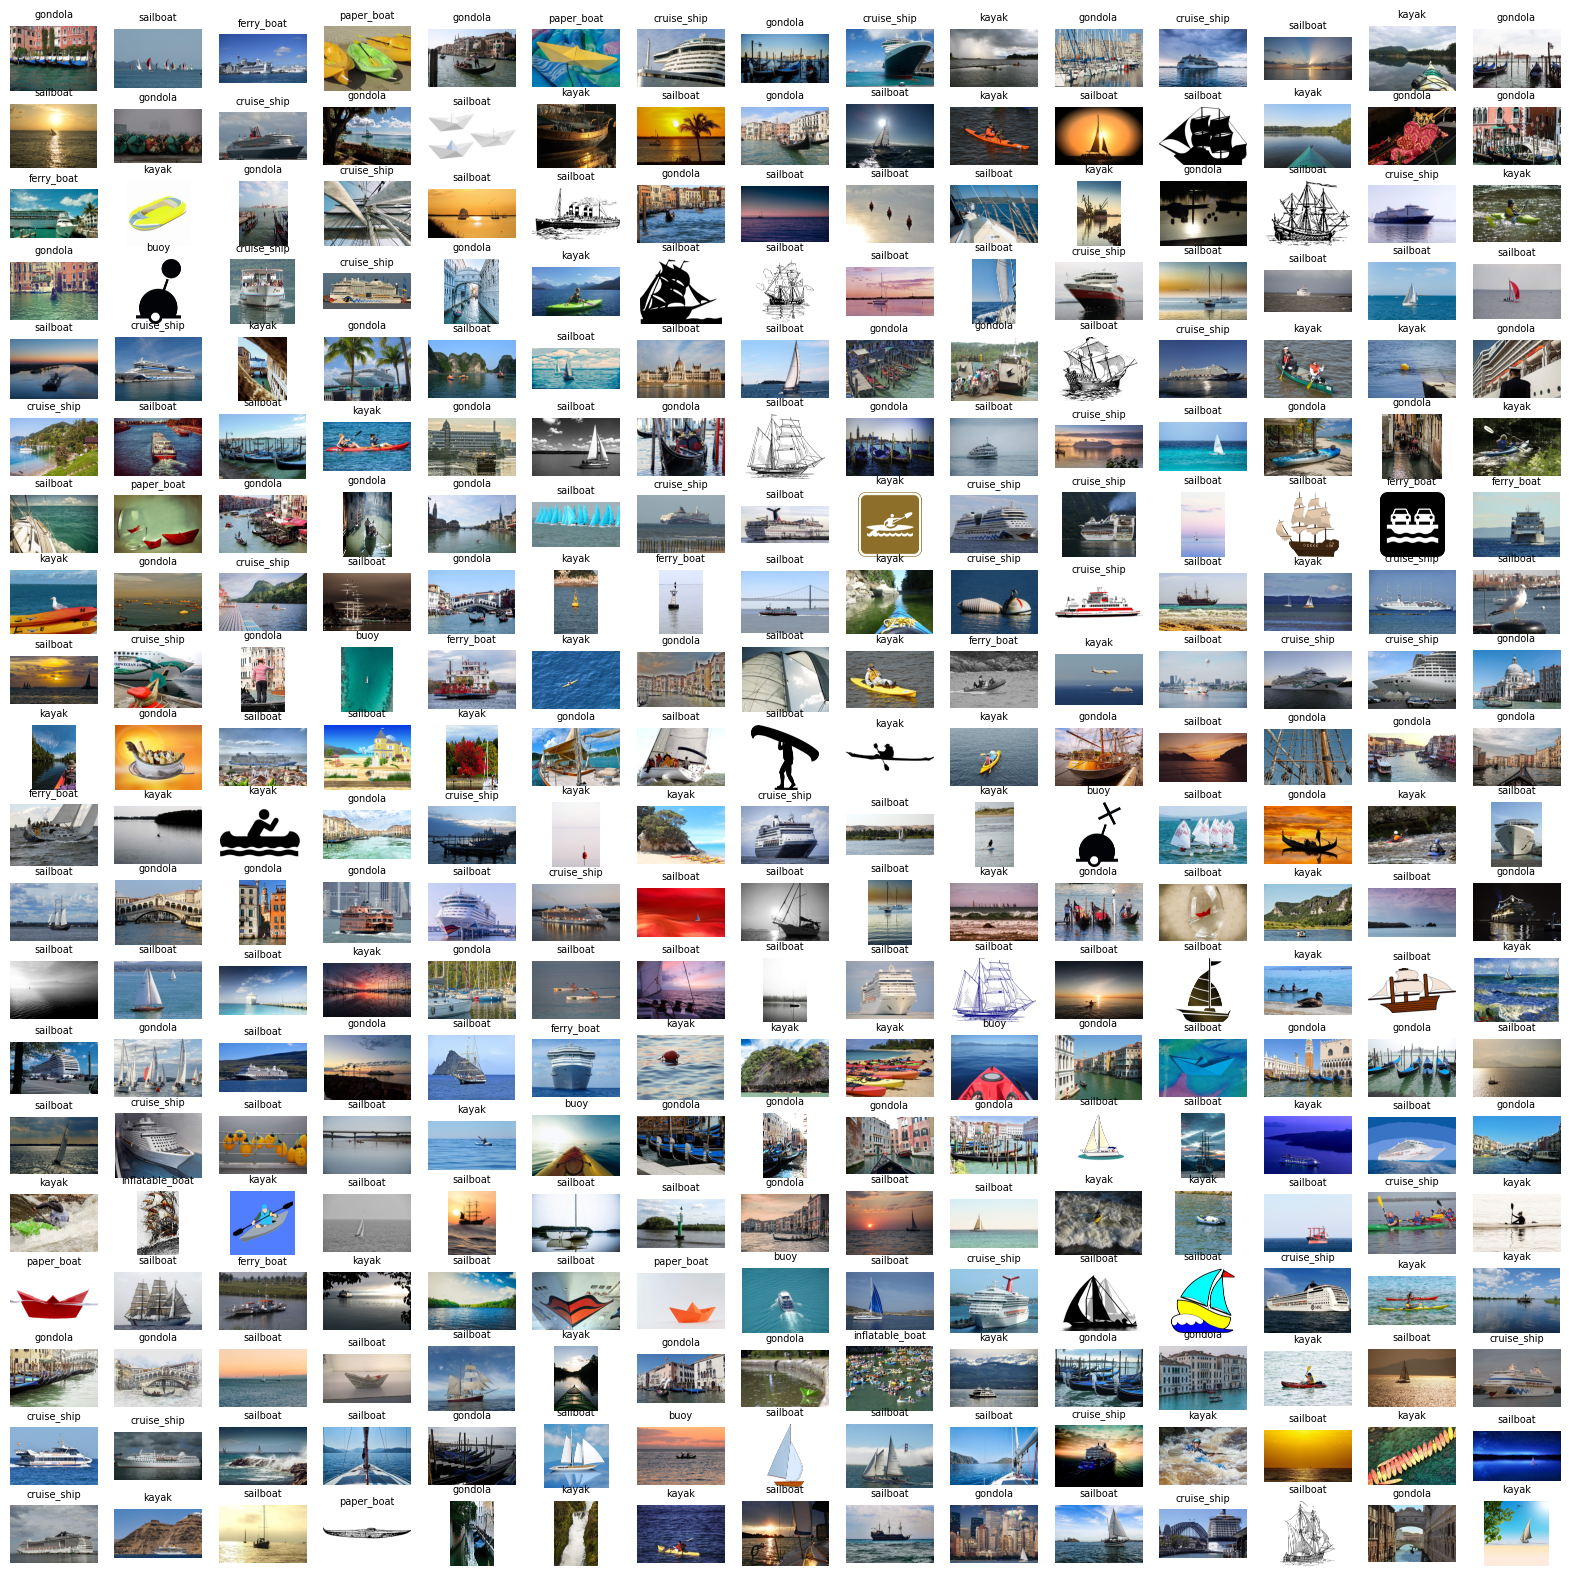

In [220]:
display_test_images(image_map,'Transfer Learning model using MobileNet')

**Metrics**

In [221]:

true_labels, predicted_labels = get_metrics(model_t,val_ds,val_split=0.3)

348 10 28
320 320


**Confusion Matrix**

Confusion Matrix
[[ 5  0  0  0  0  0  3  0  6]
 [ 0 28  5  0  3  0  6  0 14]
 [ 0  3  2  0  3  0  2  0  6]
 [ 0  1  0  0  2  0  0  0  5]
 [ 2  1  0  0 43  0  1  0  3]
 [ 1  0  0  0  0  1  1  0  0]
 [ 2  2  2  0  5  0 40  0  8]
 [ 0  0  0  0  0  0  1  4  2]
 [ 0  1  1  0  9  1  9  1 85]]

Confusion Matrix Displayed



<Figure size 1000x1000 with 0 Axes>

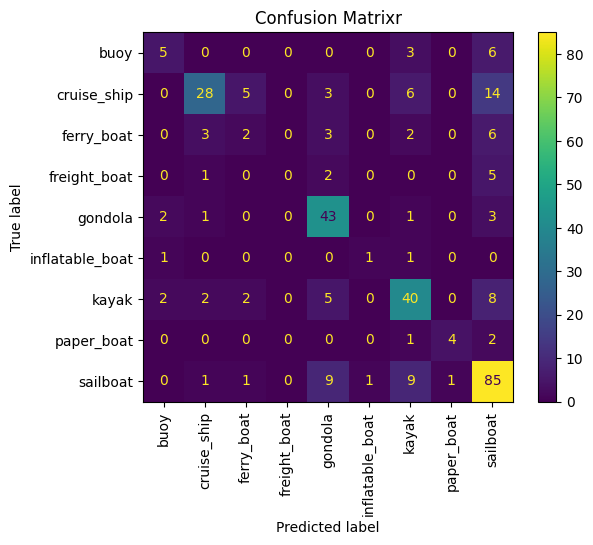

In [222]:
from sklearn.metrics import ConfusionMatrixDisplay
cm = confusion_matrix(true_labels,predicted_labels)
print('Confusion Matrix')
print(cm)
print()

print('Confusion Matrix Displayed\n')
plt.figure(figsize = (10,10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_names)
disp.plot()
plt.title('Confusion Matrixr')
plt.xticks(rotation=90)
plt.show()

**Classification Report**

In [223]:
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings('ignore')

cl_report = classification_report(true_labels,predicted_labels)
print(cl_report)

              precision    recall  f1-score   support

           0       0.50      0.36      0.42        14
           1       0.78      0.50      0.61        56
           2       0.20      0.12      0.15        16
           3       0.00      0.00      0.00         8
           4       0.66      0.86      0.75        50
           5       0.50      0.33      0.40         3
           6       0.63      0.68      0.66        59
           7       0.80      0.57      0.67         7
           8       0.66      0.79      0.72       107

    accuracy                           0.65       320
   macro avg       0.53      0.47      0.49       320
weighted avg       0.63      0.65      0.63       320



# Inferences #

The CNN model built in part 1 of this project gave an accuracy of around 65%. When tested on the 300 test images, we could see many mis-classificatons. THis could be because the training set contained just 1162 images and the code used only 80% of that for training. This is a very low number for the model to learn well. Given this limitation, an accuracy of 65% is vary good. The model has a bit of overfitting, though :


***Test accuracy: 0.6552 , train accuracy:0.7989***

> *I have used droupout for FCN as 0.5 to reduce overfitting( all lower values resulted in significant overfitting)*

The transfer learning model using MobileNet gave 81% training accuracy and about 66% test accuracy pointing to some overfitting. 


***Test accuracy:0.6580 , train accuracy:0.8170***



Transfer learning doesnt seem to improve accuracy much. This could be because the MobileNet is not trained for different boat types. Checking the 1000 classes that this model is trained in, we find that there are only 7  classes that mentiones a boat. These are 

1. pigboat,
2. submarine,U-boat
3. speedboat
4. paddle, boat paddle,
5. lifeboat.
6. fireboat,
7. boathouse

None of the above is part of our problem. So there isnt much that the MobileNet model can transfer to our model. 